In [17]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Interpolations


In [1]:
module DarkEnergyModule
    using DifferentialEquations
    using PyCall
    using Plots
    using LaTeXStrings

    # Import the Python camb module and dark energy submodule
    cb = pyimport("camb")
    DarkEnergyPPF = pyimport("camb.dark_energy").DarkEnergyPPF

    # Define a struct to encapsulate dark energy parameters
    struct DarkEnergyModel
        Ωm::Float64  # Total matter density parameter
        ΩΛ::Float64  # Dark energy density parameter
        w0::Float64  # EoS parameter
        wa::Float64  # Evolution of EoS
        h::Float64   # Hubble constant in units of 100 km/s/Mpc
        pars1::PyObject  # CAMB parameters
        results1::PyObject  # CAMB results
    end

    # Constructor with CAMB setup
    function DarkEnergyModel(Ωm::Float64, ΩΛ::Float64, w0::Float64, wa::Float64, h::Float64)
        # Calculate baryon and cold dark matter densities
        ombh2 = 0.045 * h^2  # Assuming baryon fraction is 0.045
        omch2 = (Ωm - 0.045) * h^2  # Cold dark matter density
        
        # Initialize CAMB parameters
        pars1 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        pars2 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        # Set Dark Energy equation of state
        #pars1["DarkEnergy"] = DarkEnergyPPF()
        #pars1["DarkEnergy"]["w0"] = w0
        #pars1["DarkEnergy"]["wa"] = wa
        
        # Configure matter power and non-linear settings
        pars1["set_matter_power"](redshifts=[0.0], kmax=2.0)
        pars1["NonLinear"] = cb.model["NonLinear_none"]
        results1 = cb.get_results(pars1)
        
        return DarkEnergyModel(Ωm, ΩΛ, w0, wa, h, pars1, results1)
    end

    # Dynamical dark energy equation of state
    function DE_EoS(self::DarkEnergyModel, redshift::Float64)
        w0, wa = self.w0, self.wa
        return (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
    end


    # Define methods for the DarkEnergyModel struct
    function growth(self::DarkEnergyModel, a1::Real=1e-2)
        Ωm, ΩΛ, w0, wa = self.Ωm, self.ΩΛ, self.w0, self.wa
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a1 - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E1 = √(Ωm / a1^3 + Ωk / a1^2 + ΩΛ * DEoS)
        u0 = [a1; -a1^2 * E1]
        tspan = (a1, 1.0)
        prob = ODEProblem((du, u, p, a) -> growth_set!(du, u, p, a, w0, wa), u0, tspan, [Ωm, ΩΛ])
        return solve(prob, Tsit5())
    end

    function growth_set!(du, u, p, a, w0, wa)
        δ, θ = u
        Ωm, ΩΛ = p
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E = √(Ωm / a^3 + Ωk / a^2 + ΩΛ * DEoS)  # E(a) = H(a)/H0
        q2ϕ = -(3 / 2) * Ωm * δ / a  # Poisson equation
        du[1] = -θ / a^2 / E  # Continuity equation
        du[2] = -θ / a + q2ϕ / a^2 / E  # Euler equation
    end

    # Redshift-dependent growth factor
    function dz(self::DarkEnergyModel, redshift::Float64)
        sol = growth(self)
        a = 1 / (1 + redshift)
        return sol(a)[1]
    end

# Growth rate calculation
    function growth_rate(self::DarkEnergyModel, redshift::Float64)
        step = 0.01  # Step size for numerical stability
        dzda = (dz(self, redshift + step) - dz(self, redshift - step)) / (2 * step)
        g = - (1 + redshift) * dzda / dz(self, redshift)
        return g
    end

    # Normalized Hubble rate
    function normalized_hubble_rate(self::DarkEnergyModel, redshift::Float64)
        Ωm, ΩΛ = self.Ωm, self.ΩΛ
        Ωk = 1 - Ωm - ΩΛ
        DEoS = DE_EoS(self, redshift)
        return √(Ωm / (1 + redshift)^(-3) + Ωk / (1 + redshift)^(-2) + ΩΛ * DEoS)
    end

    # Linear power spectrum from CAMB
    function get_power_spectrum(self::DarkEnergyModel, redshift::Float64)
        kh, z, pk_lcdm = self.results1["get_matter_power_spectrum"](minkh=1e-3, maxkh=1, npoints=100)
        kh = collect(kh)  # Convert Python arrays to Julia arrays
        pk_lcdm = collect(pk_lcdm)
        # Normalize the power spectrum using dz
        normalized_pk = pk_lcdm * (dz(self, Float64(redshift))^2 / dz(self, 0.0)^2)
        
        return kh, normalized_pk
    end

    function CMB_power_spectra(self::DarkEnergyModule.DarkEnergyModel)
    # Use CAMB results and parameters from the instance
        pars = self.pars1
        results = self.results1

    # Get CMB power spectra from CAMB
        powers = results["get_cmb_power_spectra"](pars, CMB_unit="muK")
        totCL = powers["total"]
        unlensedCL = powers["unlensed_scalar"]

    # L values: Julia is 1-based, so we adjust accordingly
        ls = 1:size(totCL, 1)
        l = collect(ls)
        return l, totCL, unlensedCL ## 1 for TT, 2 for EE and 4 for TE
    end

    # New: Velocity Power Spectrum
    function velocity_power_spectrum(self::DarkEnergyModel, redshift::Float64)
        kh, normalized_pk = get_power_spectrum(self, redshift)
        g = growth_rate(self, redshift)
        H = normalized_hubble_rate(self, redshift)
        H0 = self.h * 100.0  # Convert h to H0 in km/s/Mpc
        vps = [(g^2 * H^2 * H0^2 * (1+redshift)^2 / k^2) * pk for (k, pk) in zip(kh, normalized_pk)]
        return kh, vps
    end

   # New: Velocity Power Spectrum
    function velocity_matter_cross_power_spectrum(self::DarkEnergyModel, redshift::Float64)
        kh, normalized_pk = get_power_spectrum(self, redshift)
        g = growth_rate(self, redshift)
        H = normalized_hubble_rate(self, redshift)
        H0 = self.h * 100.0  # Convert h to H0 in km/s/Mpc
        vps = [(g * H * H0 * (1+redshift) / k) * pk for (k, pk) in zip(kh, normalized_pk)]
        return kh, vps
    end

    export dz, DarkEnergyModel, normalized_hubble_rate, get_power_spectrum, velocity_power_spectrum, CMB_power_spectra, velocity_matter_cross_power_spectrum
end


using .DarkEnergyModule
using Revise



In [23]:
# Create an instance of the DarkEnergyModel
dark_energy = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.1, -0.1, 0.7)

# Call the CMB_power_spectra function with the instance
x, y, z = DarkEnergyModule.CMB_power_spectra(dark_energy)


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 83.32885624257118 2.4703027674459825 0.02513169549295581 -3.294933937875102; 83.08274219355171 2.4688220703706687 0.025096941939265763 -3.263000849173553], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 82.35584769881865 2.0270839799303 0.0 -2.43870679633019; 82.04698413012038 2.0314431986688604 0.0 -2.393350178413402])

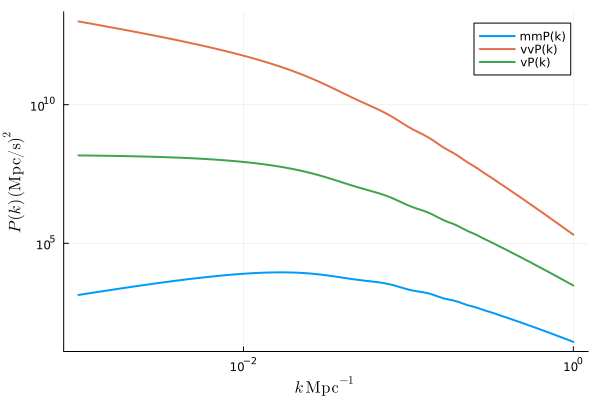

In [39]:
using .DarkEnergyModule

# Create an instance of the DarkEnergyModel
dark_energy = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.1, -0.1, 0.7)

# Get velocity power spectrum
kh, vps = DarkEnergyModule.velocity_power_spectrum(dark_energy, 0.5)
kh, pk_de = DarkEnergyModule.get_power_spectrum(dark_energy, 0.5)
kh, vpsm = DarkEnergyModule.velocity_matter_cross_power_spectrum(dark_energy, 0.5)

# Plot the normalized power spectrum
plot(
    kh, pk_lcdm_normalized[1, :],  # Normalized power spectrum at z=1
    xlabel=L"k \, \mathrm{Mpc}^{-1}", ylabel=L"P_{\delta \delta} (k)",
    xscale=:log10, 
    yscale=:log10, 
    lw=2, label="mmP(k)"
)
plot!(
    kh, vps,
    xlabel=L"k \, \mathrm{Mpc}^{-1}", ylabel=L"P(k) \, \mathrm{(Mpc/s)^2}",
    xscale=:log10, yscale=:log10,
    lw=2, label="vvP(k)"
)
plot!(
    kh, vpsm,
    xlabel=L"k \, \mathrm{Mpc}^{-1}", ylabel=L"P(k) \, \mathrm{(Mpc/s)^2}",
    xscale=:log10, yscale=:log10,
    lw=2, label="vP(k)"
)

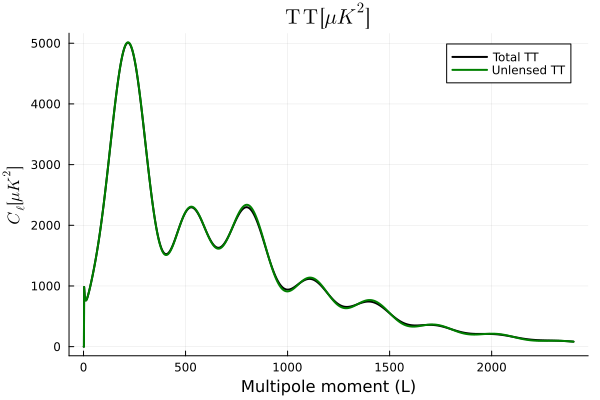

CMB TT power spectra saved as cmb_tt_power_spectra.pdf


In [25]:
        # Plot CMB power spectra
p = plot(
        x, y[:, 1], label="Total TT", color=:black, lw=2,
        xlabel="Multipole moment (L)", ylabel=L"C_\ell [\mu K^2]",
        title=L"\mathrm{TT}\, [\mu K^2]"
    )
plot!(
        p, x, z[:, 1], label="Unlensed TT", color=:green, lw=2
    )

    # Display and save the plot
display(p)
#savefig(p, "cmb_tt_power_spectra.pdf")
println("CMB TT power spectra saved as cmb_tt_power_spectra.pdf")

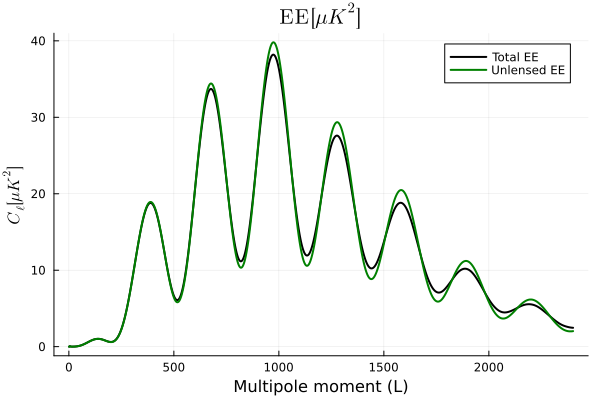

CMB EE power spectra saved as cmb_tt_power_spectra.pdf


In [27]:
        # Plot CMB power spectra
p = plot(
        x, y[:, 2], label="Total EE", color=:black, lw=2,
        xlabel="Multipole moment (L)", ylabel=L"C_\ell [\mu K^2]",
        title=L"\mathrm{EE}\, [\mu K^2]"
    )
plot!(
        p, x, z[:, 2], label="Unlensed EE", color=:green, lw=2
    )

    # Display and save the plot
display(p)
#savefig(p, "cmb_tt_power_spectra.pdf")
println("CMB EE power spectra saved as cmb_tt_power_spectra.pdf")

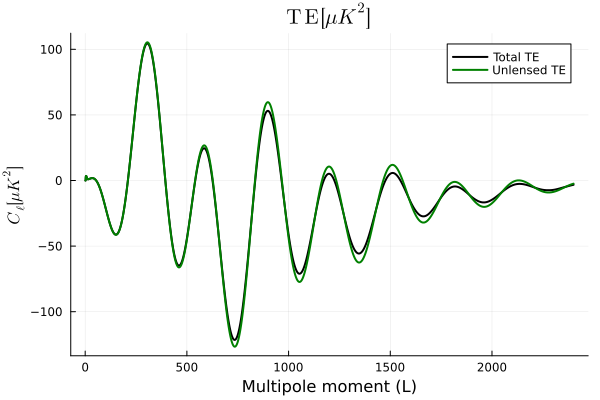

CMB TE power spectra saved as cmb_tt_power_spectra.pdf


In [29]:
        # Plot CMB power spectra
p = plot(
        x, y[:, 4], label="Total TE", color=:black, lw=2,
        xlabel="Multipole moment (L)", ylabel=L"C_\ell [\mu K^2]",
        title=L"\mathrm{TE}\, [\mu K^2]"
    )
plot!(
        p, x, z[:, 4], label="Unlensed TE", color=:green, lw=2
    )

    # Display and save the plot
display(p)
#savefig(p, "cmb_tt_power_spectra.pdf")
println("CMB TE power spectra saved as cmb_tt_power_spectra.pdf")

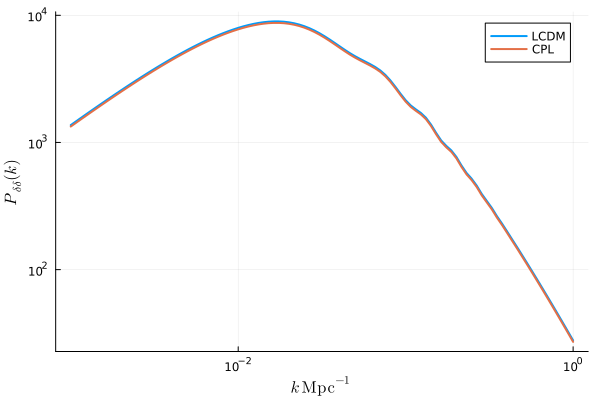

In [19]:
# Instantiate the model with parameters
dark_energy = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.1, -0.1, 0.7)
dark_energy1 = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.0, 0.0, 0.7)


# Get normalized power spectrum at z=1
kh, pk_lcdm_normalized = DarkEnergyModule.get_power_spectrum(dark_energy1, 1.0)
kh, pk_de = DarkEnergyModule.get_power_spectrum(dark_energy, 1.0)

# Plot the normalized power spectrum
plot(
    kh, pk_lcdm_normalized[1, :],  # Normalized power spectrum at z=1
    xlabel=L"k \, \mathrm{Mpc}^{-1}", ylabel=L"P_{\delta \delta} (k)",
    xscale=:log10, 
    yscale=:log10, 
    lw=2, label="LCDM"
)
plot!(
    kh,pk_de[1, :],lw=2, label="CPL")

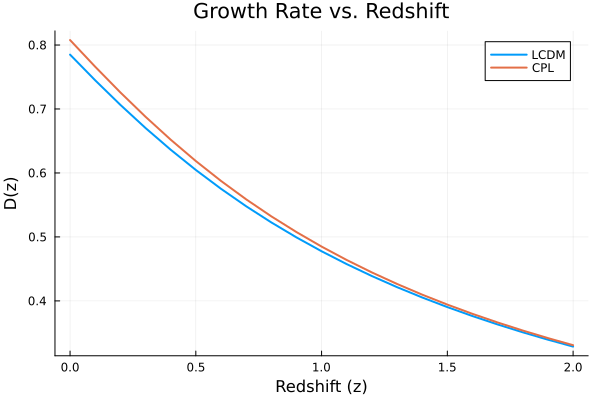

Plot saved as growth_factors_comparison.pdf


In [13]:
redshifts = collect(0.0:0.1:2.0)
lcdm_g = DarkEnergyModule.dz.(Ref(dark_energy1), redshifts)
cpl_g = DarkEnergyModule.dz.(Ref(dark_energy),redshifts)
p = plot(
    redshifts, lcdm_g,
    label="LCDM", xlabel="Redshift (z)", ylabel="D(z)",
    lw=2, legend=:topright, grid=true, title="Growth Rate vs. Redshift"
)
plot!(
    redshifts, cpl_g,
    label="CPL", xlabel="Redshift (z)", ylabel="D(z)",
    lw=2, legend=:topright, grid=true, title="Growth Rate vs. Redshift"
)
display(p)
# Save plot to a PDF file
#savefig(p, "growth_factors_comparison.pdf")

println("Plot saved as growth_factors_comparison.pdf")

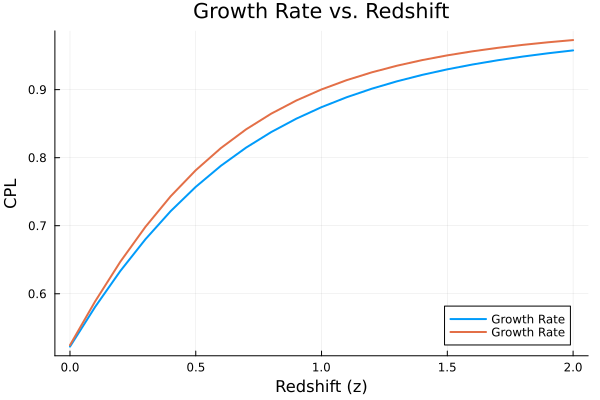

In [15]:
lcdm_growth_rates = DarkEnergyModule.growth_rate.(Ref(dark_energy1), redshifts)
cpl_growth_rates = DarkEnergyModule.growth_rate.(Ref(dark_energy),redshifts)
# Plot the growth rate vs. redshift
plot(
    redshifts, lcdm_growth_rates,
    label="Growth Rate", xlabel="Redshift (z)", ylabel="LCDM",
    lw=2, legend=:bottomright, grid=true, title="Growth Rate vs. Redshift"
)
plot!(
    redshifts, cpl_growth_rates,
    label="Growth Rate", xlabel="Redshift (z)", ylabel="CPL",
    lw=2, legend=:bottomright, grid=true, title="Growth Rate vs. Redshift"
)

BISPECTRUM ROUTINES

In [250]:
function Fs2(k1, k2)
    """
    Eq. A.2 in GGRW
    Eq. 45 in BCGS
    - k1 and k2 can be either scalars or vectors.
    """
    if isa(k1, Number) && isa(k2, Number)
        d = k1 * k2
        k1a = abs(k1)
        k2a = abs(k2)
    else
        d = dot(k1, k2)
        k1a = sqrt(dot(k1, k1))
        k2a = sqrt(dot(k2, k2))
    end
    
    if k1a < 1e-8 || k2a < 1e-8
        res = 5 / 7
    else
        rat = d / (k1a * k2a)
        res = (5 / 7) + (rat / 2) * (k1a / k2a + k2a / k1a) + (2 / 7) * rat^2
    end
    
    return res
end

function Fs2_len(k1, k2, z)
    """
    Eq. A.2 in GGRW, taking scalar or array arguments and handling
    the case when k1 or k2 are close to zero.
    
    Args:
        k1: wavenumber in h/Mpc (scalar or array)
        k2: wavenumber in h/Mpc (scalar or array)
        z: dot(k1, k2) / (|k1| |k2|) (scalar or array)
        
    Returns:
        Fs2 evaluated for wavenumbers k1, k2 with normalized dot product z.
    """
    condition = (k1 .< 1e-8) .| (k2 .< 1e-8)
    result = @. condition ? (5.0 / 7.0) : ((5.0 / 7.0) + (z / 2.0) * (k1 / k2 + k2 / k1) + (2.0 / 7.0) * z^2)
    return result
end
function Fs2_kdiff(k1, k2, μ)
    """
    Fs2(k1 - k2, k2) for scalar or array arguments k1, k2, μ.
    
    Args:
        k1: wavenumber in h/Mpc (scalar or array)
        k2: wavenumber in h/Mpc (scalar or array)
        μ: cosine of the angle between k1 and k2 (scalar or array)
        
    Returns:
        Fs2 evaluated for (k1 - k2) and k2.
    """
    x = k1.^2 .+ k2.^2 .- 2 .* k1 .* k2 .* μ
    z = (k1 .* μ .- k2) ./ x
    xrt = sqrt.(x)
    return Fs2_len(xrt, k2, z)
end
function Fs3(k1, k2, k3)
    """
    Eq. A.3 in Goroff, Grinstein, Rey, Wise (1986)
    - Supports scalar or vector arguments.
    """
    # Ensure inputs are treated as vectors if scalars
    k1 = k1 isa Number ? [k1] : k1
    k2 = k2 isa Number ? [k2] : k2
    k3 = k3 isa Number ? [k3] : k3

    k1a = dot(k1, k1)
    k2a = dot(k2, k2)
    k3a = dot(k3, k3)
    k12a = dot(k1 + k2, k1 + k2)
    k23a = dot(k2 + k3, k2 + k3)
    k123a = dot(k1 + k2 + k3, k1 + k2 + k3)

    # Terms for b1, b2, b3, b4
    b1 = (1 / 21) * dot(k1, k2) * k12a + (1 / 14) * k2a * dot(k1, k1 + k2)
    b2 = 7 * k3a * dot(k1 + k2, k1 + k2 + k3) + dot(k3, k1 + k2) * k123a
    b3 = (1 / 21) * dot(k2, k3) * k23a + (1 / 14) * k3a * dot(k2, k2 + k3)
    b4 = dot(k2, k3) * k23a + 5 * k3a * dot(k2, k2 + k3)

    # Terms for c1, c3, c4
    c1 = ifelse(k12a < 1e-8, 0.0, 1 / (3 * k1a * k2a * k3a * k12a))
    c3 = ifelse(k23a < 1e-8, 0.0, dot(k1, k2 + k3) * k123a / (3 * k1a * k2a * k3a * k23a))
    c4 = dot(k1, k1 + k2 + k3) / (18 * k1a * k2a * k3a)

    return c1 * b1 * b2 + c3 * b3 + c4 * b4
end
function Fs3_parallelogram(k1, k2, μ)
    """
    Eq. A.3 in GGRW for the special case F3(k1, -k1, k2)
    
    Args:
        k1: wavenumber in h/Mpc (scalar)
        k2: wavenumber in h/Mpc (scalar)
        μ: cosine of the angle between the wavevectors k1 and k2 (scalar)
        
    Returns:
        Fs3 evaluated for the special arguments k1, -k1, k2
    """
    x = k2 / k1
    y = x * μ - 1.0
    z = 1.0 + x^2 - 2.0 * x * μ

    term1 = (1 / 21) * x * y * ((μ / 3) + 0.5 * x * y / z)
    term2 = -(μ / 18) * (μ * z + 5 * x * y)

    return term1 + term2
end


function alpha_BCGS(k1, k2)
    """
    Eq. 39 from Ref BCGS
    """
    k1 = Float64.(k1)
    k2 = Float64.(k2)
    k1sq = dot(k1, k1)
    if k1sq == 0.0
        return 0.0
    else
        return dot(k1 + k2, k1) / k1sq
    end
end

function gamma_BCGS(k1, k2)
    """
    Eq. 68 from Ref BCGS
    """
    k1 = Float64.(k1)
    k2 = Float64.(k2)
    k1a = dot(k1, k1)
    k2a = dot(k2, k2)
    if k1a * k2a == 0.0
        return 0.0
    else
        return 1 - (dot(k1, k2))^2 / (k1a * k2a)
    end
end


function F3(k1, k2, k3)
    """
    Eq. 73 in BCGS
    - k arguments can be scalars or vectors.
    """
    # Ensure inputs are vectors
    k1 = typeof(k1) <: Number ? [k1] : k1
    k2 = typeof(k2) <: Number ? [k2] : k2
    k3 = typeof(k3) <: Number ? [k3] : k3

    # Constants as per Eq. 52 and Eq. 67 in BCGS
    nu2 = 34 / 21        # Eq. 52 in BCGS
    nu3 = 682 / 189      # Eq. 52 in BCGS
    lambda3 = 9 / 10     # Eq. 67 in BCGS

    # Vector sums
    k12 = k1 .+ k2

    # Compute gamma and alpha terms
    g312 = gamma_BCGS(k3, k12)
    g12 = gamma_BCGS(k1, k2)

    R11 = (0.5 * alpha_BCGS(k3, k12) + 0.5 * alpha_BCGS(k12, k3) -
           (1 / 3) * g312) * alpha_BCGS(k1, k2)

    R12 = (-1.5 * alpha_BCGS(k12, k3) - (4 / 3) * alpha_BCGS(k3, k12) +
           2.5 * g312) * g12

    R2 = 0.75 * (alpha_BCGS(k3, k12) + alpha_BCGS(k12, k3) - 3 * g312) * g12

    R3 = (3 / 8) * g312 * g12

    R4 = ((2 / 3) * g312 * alpha_BCGS(k1, k2) -
          ((1 / 3) * alpha_BCGS(k3, k12) + 0.5 * g312) * g12)

    return (R11 + R12) + nu2 * R2 + nu3 * R3 + lambda3 * R4
end
function Fs3_BCGS(k1, k2, k3, F3_func=nothing)
    """
    Compute Fs3 using the BCGS formula.
    
    Args:
        k1, k2, k3: Scalars or vectors representing wavevectors.
        F3_func: Optional custom F3 function. Defaults to the defined `F3`.

    Returns:
        Fs3 averaged over all permutations of (k1, k2, k3).
    """
    if F3_func === nothing
        F3_func = F3
    end

    return (F3_func(k1, k2, k3) +
            F3_func(k3, k1, k2) +
            F3_func(k2, k3, k1) +
            F3_func(k2, k1, k3) +
            F3_func(k3, k2, k1) +
            F3_func(k1, k3, k2)) / 6.0
end


Fs3_BCGS (generic function with 2 methods)

In [252]:


function bispectrum(k1, k2, k3, Fs2, dark_energy_model, redshift)
    """
    Perturbation theory bispectrum (eq. 22 in Cooray and Hu (2000))
    
    Args:
        k1, k2, k3: Scalars or vectors representing wavevectors.
        Fs2: Function to compute Fs2.
        dark_energy_model: Instance of the dark energy model.
        z: Redshift at which to compute the power spectrum.

    Returns:
        Bispectrum value.
    """
    # Get the power spectrum (kh and pk) at the specified redshift
    kh, pk = DarkEnergyModule.get_power_spectrum(dark_energy_model, redshift)

    # Extract the first row of pk (using CAMB, matrix format)
    pk_row = pk[1, :]

    # Create an interpolation object for the power spectrum
    power_interp = interpolate((kh,), pk_row, Gridded(Linear()))

    # Define a function to evaluate the interpolated power spectrum
    linear_power_func = x -> x < minimum(kh) || x > maximum(kh) ? 0.0 : power_interp(x)

    # Magnitudes of k1, k2, k3
    k1a = sqrt(dot(k1, k1))
    k2a = sqrt(dot(k2, k2))
    k3a = sqrt(dot(k3, k3))

    # Linear power spectrum for the magnitudes
    p1 = linear_power_func(k1a)
    p2 = linear_power_func(k2a)
    p3 = linear_power_func(k3a)

    # Compute the bispectrum
    res = 2.0 * (Fs2(k1, k2) * p1 * p2 +
                 Fs2(k1, k3) * p1 * p3 +
                 Fs2(k2, k3) * p2 * p3)
    return res
end


bispectrum (generic function with 1 method)

In [199]:
# Assuming you have already initialized the dark energy model
dark_energy_test = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.1, -0.1, 0.7)

# Wavevectors
k1 = [0.1, 0.5, 0.4] #kx, ky, kz
k2 = [0.2, 0.6, 0.7]
k3 = [0.3, 0.1, 0.2]

k11 = [0.3, 0.1, 0.2]
k22 = [0.2, 0.6, 0.7]
k33 = [0.1, 0.5, 0.4]

# Compute bispectrum at z=1
result = bispectrum(k1, k2, k3, Fs2, dark_energy_test, 1.0)
println("Bispectrum result: $result")


Bispectrum result: 7492.815968594449


In [211]:
#result = bispectrum(0.1, 0.2, 0.3, Fs2, dark_energy_test, 1.0)
#println("Bispectrum result: $result")

In [223]:
# Define multiple sets of wavevectors
wavevector_sets = [
    ([0.1, 0.5, 0.4], [0.2, 0.6, 0.7], [0.3, 0.1, 0.2]), # k1, k2, k3
    ([0.3, 0.1, 0.2], [0.2, 0.7, 0.7], [0.2, 0.5, 0.4]), # k11, k22, k33
    # Add more sets here if needed
]
# Compute magnitudes of k1, k2, k3 for each set
for (i, (k1, k2, k3)) in enumerate(wavevector_sets)
    # Compute magnitudes
    k1_mag = norm(k1)
    k2_mag = norm(k2)
    k3_mag = norm(k3)
    
    println("Set $i:")
    println("|k1| = $k1_mag, |k2| = $k2_mag, |k3| = $k3_mag")
end

# Iterate over wavevector sets and compute the bispectrum for each
for (i, (k1, k2, k3)) in enumerate(wavevector_sets)
    # Compute bispectrum
    result = bispectrum(k1, k2, k3, Fs2, dark_energy_test, 1.0)
    println("Bispectrum result for set $i: $result")
end


Set 1:
|k1| = 0.6480740698407861, |k2| = 0.9433981132056604, |k3| = 0.37416573867739417
Set 2:
|k1| = 0.37416573867739417, |k2| = 1.0099504938362076, |k3| = 0.6708203932499369
Bispectrum result for set 1: 88297.56507469404
Bispectrum result for set 2: 53239.26596049136


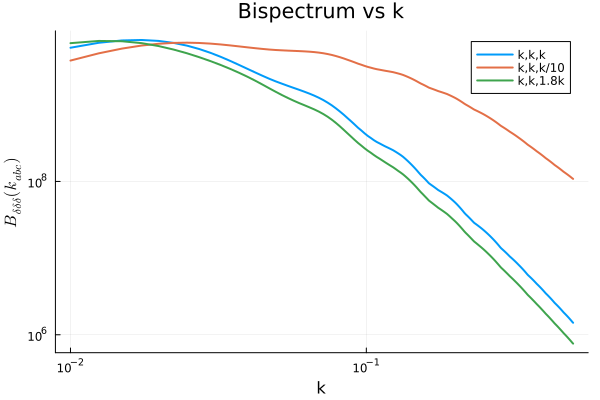

In [266]:
# Generate k1, k2, and k3 ranges
k1 = range(0.01, 0.5, length=200)
k2 = k1
k3 = k1 #./ 10
k4 = k1 ./ 10
k5 = k1 .*1.8
# Compute bispectrum results
results = Float64[]
for i in eachindex(k1)
    result = bispectrum([k1[i], 0.0, 0.0], [k2[i], 0.0, 0.0], [k3[i], 0.0, 0.0], Fs2, dark_energy_test, 0.0)
    push!(results, result)
end

results1 = Float64[]
for i in eachindex(k1)
    result1 = bispectrum([k1[i], 0.0, 0.0], [k2[i], 0.0, 0.0], [k4[i], 0.0, 0.0], Fs2, dark_energy_test, 0.0)
    push!(results1, result1)
end
results2 = Float64[]
for i in eachindex(k1)
    result2 = bispectrum([k1[i], 0.0, 0.0], [k2[i], 0.0, 0.0], [k5[i], 0.0, 0.0], Fs2, dark_energy_test, 0.0)
    push!(results2, result2)
end
# Plot the bispectrum results
plot(k1, results, xlabel="k", ylabel=L"B_{\delta\delta\delta}(k_{abc})", xscale=:log10, yscale=:log10,title="Bispectrum vs k", label="k,k,k", lw=2)
plot!(k1, results1, xlabel="k", ylabel=L"B_{\delta\delta\delta}(k_{abc})", xscale=:log10, yscale=:log10,title="Bispectrum vs k", label="k,k,k/10", lw=2)
plot!(k1, results2, xlabel="k", ylabel=L"B_{\delta\delta\delta}(k_{abc})", xscale=:log10, yscale=:log10,title="Bispectrum vs k", label="k,k,1.8k", lw=2)


https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.083517

In [ ]:
# Assuming you have already initialized the dark energy model
dark_energy_test = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.1, -0.1, 0.7)

# Wavevectors
k1 = range(0.01,0.5,20steps)
k2 = k1
k3 = k1/10


# Compute bispectrum at z=1
result = bispectrum(k1, k2, k3, Fs2, dark_energy_test, 1.0)
println("Bispectrum result: $result")
plot(k1,result)

In [1]:
llist = 10:20:3000  # Start at 10, increment by 20, stop at 3000
println(llist)

10:20:2990
